# **Stroke**

# **Libraries**

In [312]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from feature_engine.imputation import AddMissingIndicator
from feature_engine.imputation import MeanMedianImputer
from feature_engine.encoding import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from statsmodels.stats.proportion import proportions_ztest
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import mutual_info_classif

from scipy import stats

from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC


from sklearn.metrics import classification_report

import warnings

# **Display Parameters**

## **Display Features**

In [99]:
%matplotlib inline

pd.options.display.max_rows = 300000
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 500

warnings.filterwarnings("ignore")
warnings.simplefilter(action="ignore", category=FutureWarning)

## **Colors**

In [3]:
color_1 = "bisque"
color_2 = "crimson"
color_3 = "orangered"
color_4 = "lightcoral"
color_5 = "royalblue"
color_6 = "pink"
color_7 = "indianred"
color_8 = "slategrey"
color_9 = "salmon"
color_10 = "beige"
color_11 = "coral"
color_13 = "grey"
color_14 = "tan"
color_15 = "wheat"
color_16 = "tomato"

## **Figure Parameters**

In [4]:
size = 20

params = {
    "font.family": "Times New Roman",
    "font.size": size,
    "axes.labelsize": size,
    "xtick.labelsize": size * 0.75,
    "ytick.labelsize": size * 0.75,
    "figure.titlesize": size * 1.5,
    "axes.titlesize": size * 1.5,
    "axes.titlepad": size,
    "axes.labelpad": size - 10,
    "lines.linewidth": 2,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.spines.left": False,
    "axes.spines.bottom": False,
    "legend.fontsize": size,
    "figure.figsize": (10, 6),
}

# **Data Overview and Preprocessing**

In [187]:
data = pd.read_csv(
    r"C:\Users\Dell\Documents\Stroke\Data\stroke.csv",
    index_col=0
)

data = data.drop(columns=['ID'])
target = 'Stroke'

In [159]:
data.head()

,Gender,Age,Hypertension,Heart Disease,Ever Married,Work,Residence,AVG Glucose,BMI,Smoking,Stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## **Number of Rows and Columns**

In [ ]:
data.shape

## **Missing Data**

In [ ]:
data.isnull().sum(axis=0)

# **Descriptive Information**

## **Data Types**

In [76]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5109 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Gender         5109 non-null   object 
 1   Age            5109 non-null   float64
 2   Hypertension   5109 non-null   int64  
 3   Heart Disease  5109 non-null   int64  
 4   Ever Married   5109 non-null   object 
 5   Work           5109 non-null   object 
 6   Residence      5109 non-null   object 
 7   AVG Glucose    5109 non-null   float64
 8   BMI            4908 non-null   float64
 9   Smoking        5109 non-null   object 
 10  Stroke         5109 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 479.0+ KB


## **Descriptive Information for Numerical Features**

In [ ]:
data.drop(columns=['Stroke']).describe(include="number").applymap("{:,.2f}".format)

,Age,Hypertension,Heart Disease,AVG Glucose,BMI
count,"5,109.00","5,109.00","5,109.00","5,109.00","4,908.00"
mean,43.23,0.10,0.05,106.14,28.89
std,22.61,0.30,0.23,45.29,7.85
min,0.08,0.00,0.00,55.12,10.30
25%,25.00,0.00,0.00,77.24,23.50
50%,45.00,0.00,0.00,91.88,28.10
75%,61.00,0.00,0.00,114.09,33.10
max,82.00,1.00,1.00,271.74,97.60


## **Descriptive Information for Categorical Features**

In [85]:
data.describe(include="object")

,Gender,Ever Married,Work,Residence,Smoking
count,5109,5109,5109,5109,5109
unique,2,2,5,2,4
top,Female,Yes,Private,Urban,never smoked
freq,2994,3353,2924,2596,1892


# **Stroke and Non-Stroke Patients**

In [160]:
engineered_data = data.copy()

In [161]:
stroke = engineered_data[engineered_data[target] == 1]
no_stroke = engineered_data[engineered_data[target] == 0]

## **Outliers**

An outlier is an observation that is unlike the other observations.

I used the **Interquartile Range (IQR)** method to identify outliers. The IQR is calculated as the difference between the 75th and the 25th percentiles of the data and defines the box in a box and whisker plot. The whiskers indicate the minimum and the maximum values. Any values that is 1.5 times the IQR value above Q3 and 1.5 times the IQR value below Q1 will be considered an outlier. These are indicated as dots in a box and whisker plot.

In [162]:
numeric_data = engineered_data.select_dtypes(include=['number'])

# Calculate Q1 (25th percentile) and Q3 (75th percentile) for numeric columns
Q1 = numeric_data.quantile(0.25)
Q3 = numeric_data.quantile(0.75)

IQR = Q3 - Q1

outliers = (numeric_data < (Q1 - 1.5 * IQR)) | (numeric_data > (Q3 + 1.5 * IQR))

outlier_counts = outliers.sum()

print(outlier_counts)


Age                0
Hypertension     498
Heart Disease    276
AVG Glucose      627
BMI              110
Stroke           249
dtype: int64


In [163]:
engineered_data ['Is Outlier'] = outliers.any(axis=1)
engineered_data['Is Outlier'] = engineered_data['Is Outlier'].astype(object)
engineered_data['Is Outlier'].value_counts()

Is Outlier
False    3823
True     1286
Name: count, dtype: int64

# **Impute missing values for BMI Data**

## **Add Missing Indicator**

In [164]:
ami = AddMissingIndicator()
engineered_data = ami.fit_transform(engineered_data)

engineered_data = engineered_data.rename(columns={'BMI_na': 'BMI Missing'})
data = engineered_data.drop(columns=['BMI Missing'])

In [165]:
engineered_data.head()

,Gender,Age,Hypertension,Heart Disease,Ever Married,Work,Residence,AVG Glucose,BMI,Smoking,Stroke,Is Outlier,BMI Missing
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,True,0
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1,True,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,True,0
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1,True,0
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,True,0


## **Median Imputer**

In [166]:
mmi = MeanMedianImputer(imputation_method='median')
engineered_data = mmi.fit_transform(engineered_data)

In [167]:
engineered_data.isnull().sum(axis=0)

Gender           0
Age              0
Hypertension     0
Heart Disease    0
Ever Married     0
Work             0
Residence        0
AVG Glucose      0
BMI              0
Smoking          0
Stroke           0
Is Outlier       0
BMI Missing      0
dtype: int64

# **Functions**

## **Barplots**

In [13]:
def barplot(data, x, y, xlabel, ylabel, labels, title):

    plt.rcParams.update(params)
    
    ax = sns.barplot(
        x=x,
        y=y,
        data=data,
        palette="Reds",
        order=labels
    )
    
    total = data[y].sum()
    
    for p in ax.patches:
        height = p.get_height()
        percentage = "{:.1f}%".format(100 * height / total)
        x_position = p.get_x() + p.get_width() / 2
        y_position = height
        ax.annotate(percentage, (x_position, y_position), ha='center', va='bottom', size=12)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

## **Distributions**

In [14]:
def distributions(df, feature, target):
    
    distribution = df.groupby(feature)[target].sum().reset_index()
    distribution.columns = [feature, 'Count']

    return distribution

## **Bins**

In [15]:
def create_bins(df, feature, new_feature, bins, labels):

    df[new_feature] = pd.cut(df[feature], bins=bins, labels=labels, right=False)
    group_counts = df[new_feature].value_counts().sort_index()
    group_counts_df = group_counts.reset_index()
    group_counts_df.columns = [new_feature, 'Count']

    return group_counts_df

## **Heat Map**

In [16]:
def create_heatmap(data, title):
    """
    Creates a Seaborn heatmap.
    """

    plt.rcParams.update(params)
    corr = data.corr()

    mask = np.triu(np.ones_like(corr, dtype=bool))

    f, ax = plt.subplots(figsize=(20, 15))

    cmap = sns.diverging_palette(230, 10, as_cmap=True)
    heatmap = sns.heatmap(
        corr,
        mask=mask,
        vmax=1,
        vmin=-1,
        center=0,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.5},
        annot=True,
        cmap=plt.cm.Reds,
    )

    heatmap.set_title(
        title,
        fontdict={"fontsize": size},
        pad=12,
    )
    plt.xlabel("")
    plt.ylabel("")

# **Exploratory Data Analysis**

## **Gender**

In [ ]:
feature = 'Gender'
df = engineered_data.copy()

gender_distribution = distributions(df, feature, target)

In [ ]:
labels = ['Male', 'Female']
y = 'Count'
df = gender_distribution

x = feature
y = y
df = df
xlabel = feature
ylabel = y
lables = labels
title = 'Gender of Stroke Patients'

barplot(df, x, y, xlabel, ylabel, labels, title)

## **Hypertension**

In [ ]:
feature = 'Hypertension'
df = engineered_data.copy()

hypertension_distribution = distributions(df, feature, target)

In [ ]:
labels = [0, 1]
y = 'Count'
df = hypertension_distribution  

x = feature
y = y
df = df
xlabel = feature
ylabel = y  
lables = labels
title = 'Hypertension Among Stroke Patients'


barplot(df, x, y, xlabel, ylabel, labels, title)

## **Heart Disease**

In [ ]:
feature = 'Heart Disease'
df = engineered_data.copy()

heartdisease_distribution = distributions(df, feature, target)

In [ ]:
labels = [0, 1]
y = 'Count' 
df = heartdisease_distribution

x = feature
y = y
df = df
xlabel = feature
ylabel = y
lables = labels
title = 'Heart Disease Among Stroke Patients'


barplot(df, x, y, xlabel, ylabel, labels, title)

## **Marital Status**

In [ ]:
feature = 'Ever Married'
df = engineered_data.copy()

married_distribution = distributions(df, feature, target)

In [ ]:
labels = ['No', 'Yes']
y = 'Count'
df = married_distribution

x = feature
y = y
df = df
xlabel = feature
ylabel = y
lables = labels
title = 'Marital Status of Stroke Patients'


barplot(df, x, y, xlabel, ylabel, labels, title)

## **Work Status**

In [ ]:
feature = 'Work'
df = engineered_data.copy()

work_distribution = distributions(df, feature, target)

In [ ]:
labels = ['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked']
y = 'Count'
df = work_distribution

x = feature
y = y
df = df
xlabel = feature
ylabel = y
lables = labels
title = 'Work Status of Stroke Patients'


barplot(df, x, y, xlabel, ylabel, labels, title)

## **Residence Type**

In [ ]:
feature = 'Residence'
df = engineered_data.copy()

residence_distribution = distributions(df, feature, target)

In [ ]:
labels = ['Urban', 'Rural']
y = 'Count'
df = residence_distribution


x = feature
y = y
df = df
xlabel = feature
ylabel = y
lables = labels
title = 'Residence Type of Stroke Patients'


barplot(df, x, y, xlabel, ylabel, labels, title)

## **Average Glucose Levels**

In [ ]:
feature = 'AVG Glucose'
new_feature = 'Glucose Level'
bins = [50, 100, 150, 200, 250, 300]
labels = ['50-100', '101-150', '151-200', '201-250', '251-300']

In [ ]:
df = stroke.copy()
glucose_group_counts = create_bins(df, feature, new_feature, bins, labels)

In [ ]:
df = glucose_group_counts
x = new_feature
y = 'Count'

df = df
xlabel = new_feature
ylabel = y
labels = labels
title = 'Average Glucose Levels of Stroke Patients'


barplot(df, x, y, xlabel, ylabel, labels, title)

# **BMI Levels**

In [ ]:
feature = 'BMI'
new_feature = 'BMI Level'
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100']

In [ ]:
df = stroke.copy()   
BMI_group_counts = create_bins(df, feature, new_feature, bins, labels)

In [ ]:
y = 'Count'
df = BMI_group_counts

x = new_feature
y = y
df = df
xlabel = new_feature
ylabel = y
labels = labels
title = 'BMI Levels of Stroke Patients'

barplot(df, x, y, xlabel, ylabel, labels, title)

## **Smoking Habits**

In [ ]:
feature = 'Smoking'
df = engineered_data.copy()

smoking_distribution = distributions(df, feature, target)

In [ ]:
labels = ['Unknown', 'formerly smoked', 'never smoked', 'smokes']
y = 'Count'
df = smoking_distribution

x = feature
y = y
df = df
xlabel = feature
ylabel = y
lables = labels
title = 'Smoking Habits of Stroke Patients'


barplot(df, x, y, xlabel, ylabel, labels, title)

## **Age Range**

In [ ]:
feature = 'Age'
new_feature = 'Age Group'
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100']

In [ ]:
df = engineered_data.copy()
age_group_counts = create_bins(df, feature, new_feature, bins, labels)

In [ ]:
y = 'Count'
df = age_group_counts

x = new_feature
y = y
df = df
xlabel = new_feature
ylabel = y
labels = labels
title = 'Ages of Data Participants'


barplot(df, x, y, xlabel, ylabel, labels, title)

## **Ages of Stroke Patients**

In [ ]:
df = stroke.copy()
age_group_counts = create_bins(df, feature, new_feature, bins, labels)

In [ ]:
y = 'Count'
df = age_group_counts 

x = new_feature
y = y
df = df
xlabel = new_feature
ylabel = y
labels = labels
title = 'Ages of Stroke Patients'


barplot(df, x, y, xlabel, ylabel, labels, title)

### Section Summary
> * The age range is 25 to 35.
> * About 25% of the customers are 28, the youngest group.
> * Only 3% of the customers are 35, the oldest group.

# **Hypothesis Tests**

## **Hypothesis Test: Smoking Habits and Stroke** 

**Null**: There is no significant difference between the proporation of smokers who suffered a stroke and non-smokers.<BR>
**Alternative**: A higher proportion of smokers suffered a stroke compared to non-smokers. 

In [ ]:
df = engineered_data.copy()
feature = 'Smoking'

In [ ]:
smokers = df.loc[df[feature] == 'smokes']
count_smokers = smokers.shape[0]
count_smoker_stroke = (smokers[target] == 1).sum()
prop_smoker_stroke = count_smoker_stroke / count_smokers
print(
    f"Proportion of smokers who are suffered a stroke {prop_smoker_stroke:.3f}"
)

In [ ]:
nonsmokers = df.loc[df[feature] == 'never smoked']
count_nonsmokers = nonsmokers.shape[0]
count_nonsmoker_stroke = (nonsmokers[target] == 1).sum()
prop_nonsmoker_stroke = count_nonsmoker_stroke / count_nonsmokers
print(
    f"Proportion of nonsmokers who are suffered a stroke {prop_nonsmoker_stroke:.3f}"
)

In [ ]:
numerator = np.array([count_smoker_stroke, count_nonsmoker_stroke])
denominator = np.array([count_smokers, count_nonsmokers])

stat, pval = proportions_ztest(numerator, denominator, alternative="two-sided")

print(f"P-value: {pval:.2f}")

### Section Summary
> * A large majority of customers (over 85%) are college graduates.
> * Only about 15% of customers are non-graduates.  
> * I conducted a proportions z-test to test the hypothesis that there is no significant difference between the proportion of college graduates who bought travel insurance and non-graduates.
> * Using this test, the p-value is much greater than the significance level of 0.05. 
> * Based on this evidence, I fail to reject the null hypothesis. 
> * I can conclude that there is not enough evidence to support that there is a significant difference smokers who are stroke patients and nonsmokers who are stroke patients.

## **Hypothesis Test: Mean Glucose Level and Stroke**

**Null**: There is no significant difference between the mean AVG Glucose of patients who suffered a stroke and patients who did not.<BR>
**Alternative**: The mean AVG Glucose of patients who suffered a stroke is significantly different than the mean AVG Glucose of patients who did not. 

## **Two-Sample T-Test**

In [20]:
def two_sample_t_test(sample1, sample2, variance):
    """
    Determines if the means of two samples are significanlty different.
    """
    if variance is False:
        print("The variance of the samples are different.")
    else:
        print("The variance of the samples are the same.")

    result = stats.ttest_ind(sample1, sample2, equal_var=variance)
    
    print("The p-value is: ", result.pvalue)
    
    if result.pvalue < 0.05:
        print("Null hypothesis is rejected.")
    else:
        print("Failed to reject the null hypothesis.")

In [26]:
no_stroke_glucose = no_stroke['AVG Glucose']
stroke_glucose = stroke['AVG Glucose']

## **Numpy Variance Test**

In [28]:
var_non_stroke_glucose = np.var(no_stroke_glucose)
var_stroke_glucose = np.var(stroke_glucose)

if var_non_stroke_glucose == var_stroke_glucose:
    variance = True
else:
    variance = False

## **Two-Sample T-Test**

In [29]:
pvalue = two_sample_t_test(no_stroke_glucose,stroke_glucose, variance)

The variance of the samples are different.
The p-value is:  2.3731240539507297e-11
Null hypothesis is rejected.


### **Section Summary**
> * I conducted a two-sample t-test to test this hypothesis, which required a check for variance differences between the samples. The Numpy variance test indicated that the variances of the sample are different. 
> * The p-value obtained is almost zero, so it is much smaller than the significance level of 0.05. 
> * The NULL HYPOTHESIS was REJECTED, indicating that there is a statistically significant difference between the mean number of goals made at home games and the mean number of goals made at away games. 

# **Encoding**

In [178]:
engineered_data_encoded = engineered_data.copy()

label_encoder = LabelEncoder()

obj = engineered_data_encoded.dtypes == "object"

for col in list(obj[obj].index):
    engineered_data_encoded[col] = label_encoder.fit_transform(data[col])

In [169]:
engineered_data_encoded.head()

,Gender,Age,Hypertension,Heart Disease,Ever Married,Work,Residence,AVG Glucose,BMI,Smoking,Stroke,Is Outlier,BMI Missing
0,1,67.0,0,1,1,2,1,228.69,36.6,1,1,1,0
1,0,61.0,0,0,1,3,0,202.21,28.1,2,1,1,1
2,1,80.0,0,1,1,2,0,105.92,32.5,2,1,1,0
3,0,49.0,0,0,1,2,1,171.23,34.4,3,1,1,0
4,0,79.0,1,0,1,3,0,174.12,24.0,2,1,1,0


## **Correlation between each Feature and the Target Feature**

In [179]:
corr_matrix = engineered_data_encoded.corr(numeric_only=True)
corr_matrix['Stroke'].sort_values(ascending=False)

Stroke           1.000000
Is Outlier       0.390268
Age              0.245239
BMI Missing      0.141231
Heart Disease    0.134905
AVG Glucose      0.131991
Hypertension     0.127891
Ever Married     0.108299
BMI              0.036075
Smoking          0.028108
Residence        0.015415
Gender           0.009081
Work            -0.032323
Name: Stroke, dtype: float64

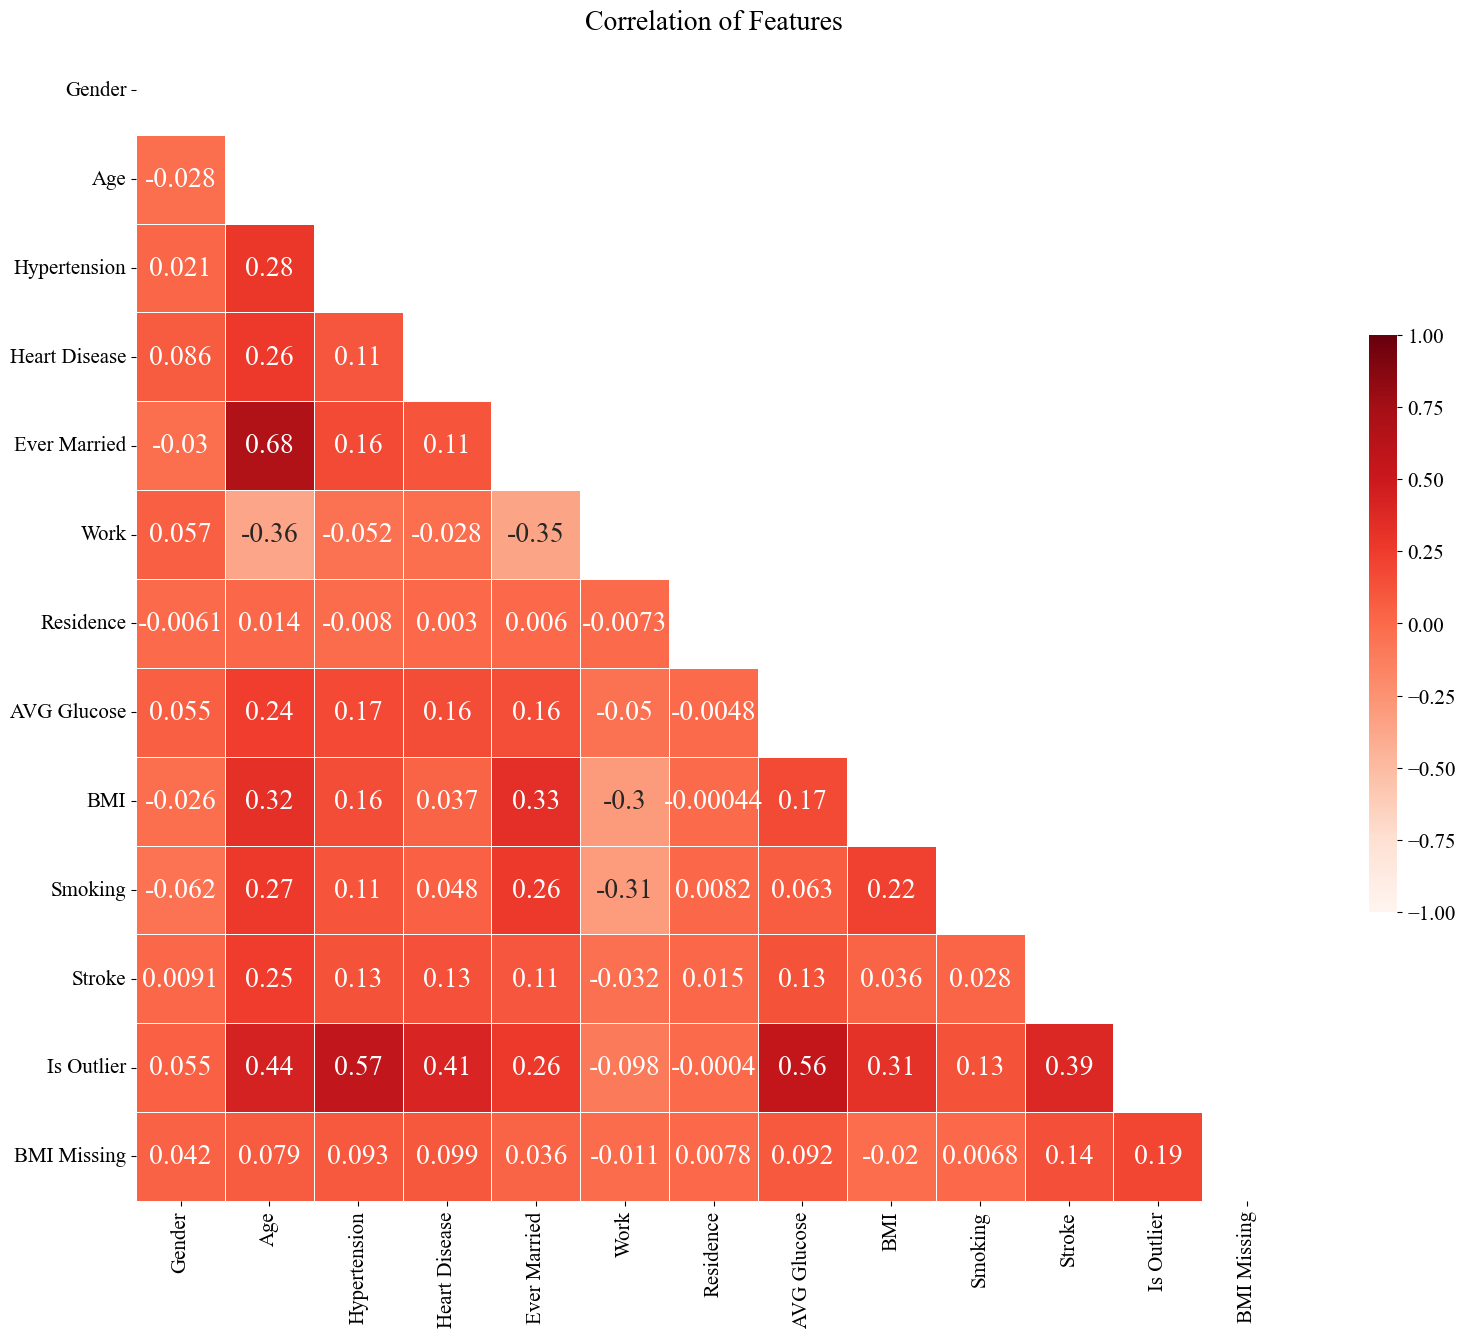

In [172]:
title = "Correlation of Features"
create_heatmap(engineered_data_encoded, title)

In [41]:
def plot_mi_scores(features, mi_scores):

    plt.rcParams.update(params)
    
    scores = pd.Series(mi_scores, name="MI Scores", index=features.columns)
    scores = scores.sort_values(ascending=False)

    plt.figure(figsize=(15, 6))
    scores.plot(kind="line", marker='o')

    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    plt.title("Mutual Information Scores")
    plt.xlabel("Feature")
    plt.ylabel("MI Score")
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.show()

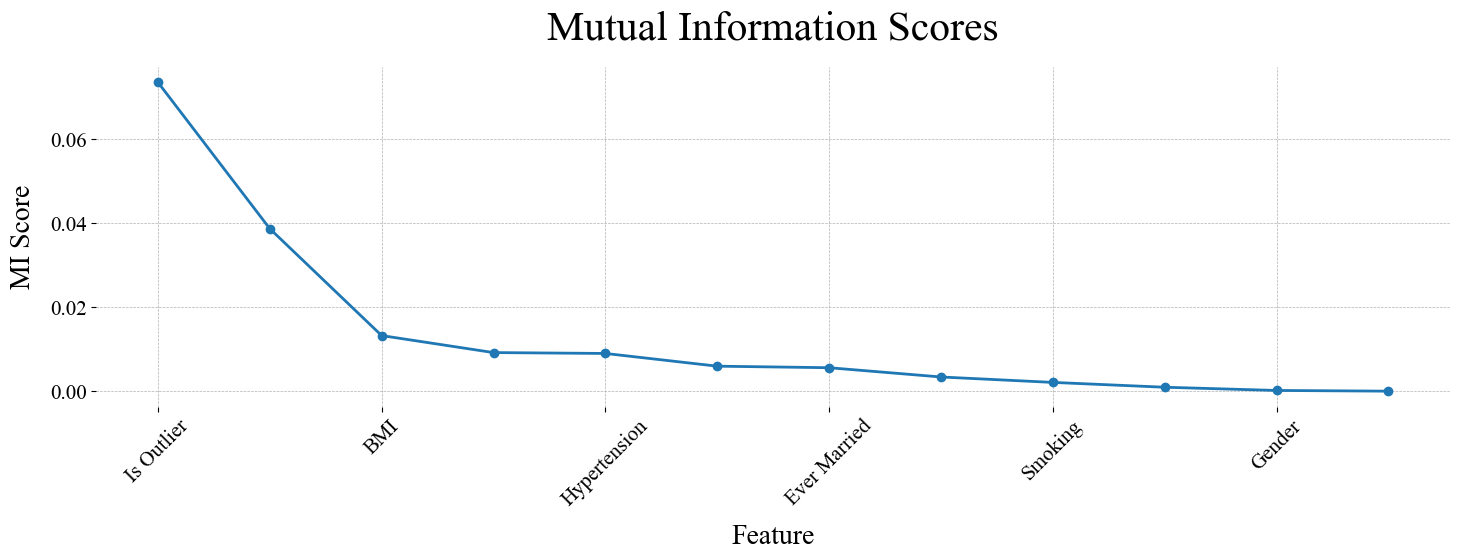

In [180]:
random_seed = 101

df = engineered_data_encoded.copy()
features = df.drop('Stroke', axis=1)
target = df['Stroke']

mi_scores = mutual_info_classif(features, target, random_state=random_seed)
plot_mi_scores(features, mi_scores)

### Section Summary
> * For this project a strong correlation would be a Pearson correlation coefficient of 0.8 or higher. 
> * There are very weak correlations between any one numeric feature and the other numeric features.
> * Furthermore, the correlations between each numeric feature and the target feature are also very weak.

# **Machine Learning**

## **Functions Used in This Section**

### **Classification Report**

In [ ]:
def print_classification_report(y_test, y_predict):
    """
    Displays the classification report.
    """

    print(classification_report(y_test, y_predict))

### **ROC Curve**

In [ ]:
def display_roc_curve(log_model, X_test, y_test, y_predict):
    """
    Displays the Receiver Operating Characteristic (ROC) Curve.
    """

    plt.rcParams.update(params)
    sns.despine(left=True, bottom=True)

    logit_roc_auc = roc_auc_score(y_test, y_predict)
    fpr, tpr, thresholds = roc_curve(y_test, log_model.predict_proba(X_test)[:, 1])

    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, label="Logistic Regression (area = %0.2f)" % logit_roc_auc)
    plt.plot([0, 1], [0, 1], "r--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic Curve")
    plt.legend(loc="lower right")

    plt.show()

# **Feature Engineering**

In [297]:
df = engineered_data_encoded.copy()

## **Drop Correlated Feature**

In [298]:
df = df.drop(columns=['Ever Married'])

## **Age Squared**

In [299]:
df['Age Squared'] = df['Age'] ** 2

## **AVG Glucose Squared**

In [300]:
df['AVG Glucose Squared'] = df['AVG Glucose'] ** 2

## **Glucose Level Bins**

In [301]:
df['Glucose Level'] = pd.cut(df['AVG Glucose'], bins=[50, 100, 150, 200, 250, 300], labels=['Very Low', 'Low', 'Normal', 'High', 'Very High'])
df['Glucose Level'] = df['Glucose Level'].astype('object')

## **BMI Level Bins**

In [302]:
df['BMI Level'] = pd.cut(df['BMI'], bins=[10, 30, 50, 70, 90, 100], labels=['Very Low', 'Low', 'Normal', 'High', 'Very High'])
df['BMI Level'] = df['BMI Level'].astype('object')

## **Hypertension and Heart Disease Interaction**

In [303]:
df['Hypertension/Heart Disease'] = df['Hypertension'].astype(str) + '_' + df['Heart Disease'].astype(str)
df['Hypertension/Heart Disease'] = df['Hypertension/Heart Disease'] .astype('object')

# **Train Test Split**

In [304]:
random_state = 101

X = df.drop(target, axis=1)
y = df[target]

X, y = shuffle(X, y, random_state=random_state)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_state)

## **Encoding**

In [305]:
ohe = OneHotEncoder()
X_train_coded = ohe.fit_transform(X_train)
X_test_coded = ohe.transform(X_test)

## **Scaling**

In [306]:
columns = ['Age', 'AVG Glucose', 'BMI', 'Age Squared', 'AVG Glucose Squared']
scaler = RobustScaler()

In [307]:
X_train_scaled = X_train_coded.copy()
X_train_scaled[columns] = scaler.fit_transform(X_train_scaled[columns])

X_test_scaled = X_test_coded.copy()
X_test_scaled[columns] = scaler.transform(X_test_scaled[columns])

## **Class Weights**

In [ ]:
weights = {0: 1, 1: 10}

# LogisticRegression(class_weight=weights)
# model.fit(X_train, y_train)

# K-Fold Cross Validation

In [314]:
logisticregression_pipeline = Pipeline([("lr", LogisticRegression())])

svm_pipeline = Pipeline([SVC()]) 

knn_pipeline = Pipeline([("knn", KNeighborsClassifier())])


pipelines = {
    "Logistic Regression": logisticregression_pipeline,
    "SVM": svm_pipeline,
    "KNN": knn_pipeline,
}


for name, pipeline in pipelines.items():
    scores = cross_val_score(pipeline, X, y, cv=10)
    print(f"{name}: {scores.mean():.2f}")

ValueError: 
All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Dell\Documents\Stroke\strokevenv\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Dell\Documents\Stroke\strokevenv\lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Dell\Documents\Stroke\strokevenv\lib\site-packages\sklearn\pipeline.py", line 476, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\Dell\Documents\Stroke\strokevenv\lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Dell\Documents\Stroke\strokevenv\lib\site-packages\sklearn\linear_model\_logistic.py", line 1223, in fit
    X, y = self._validate_data(
  File "c:\Users\Dell\Documents\Stroke\strokevenv\lib\site-packages\sklearn\base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "c:\Users\Dell\Documents\Stroke\strokevenv\lib\site-packages\sklearn\utils\validation.py", line 1273, in check_X_y
    X = check_array(
  File "c:\Users\Dell\Documents\Stroke\strokevenv\lib\site-packages\sklearn\utils\validation.py", line 1007, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "c:\Users\Dell\Documents\Stroke\strokevenv\lib\site-packages\sklearn\utils\_array_api.py", line 746, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
  File "c:\Users\Dell\Documents\Stroke\strokevenv\lib\site-packages\pandas\core\generic.py", line 2153, in __array__
    arr = np.asarray(values, dtype=dtype)
ValueError: could not convert string to float: 'Very Low'

--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Dell\Documents\Stroke\strokevenv\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Dell\Documents\Stroke\strokevenv\lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Dell\Documents\Stroke\strokevenv\lib\site-packages\sklearn\pipeline.py", line 476, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\Dell\Documents\Stroke\strokevenv\lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Dell\Documents\Stroke\strokevenv\lib\site-packages\sklearn\linear_model\_logistic.py", line 1223, in fit
    X, y = self._validate_data(
  File "c:\Users\Dell\Documents\Stroke\strokevenv\lib\site-packages\sklearn\base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "c:\Users\Dell\Documents\Stroke\strokevenv\lib\site-packages\sklearn\utils\validation.py", line 1273, in check_X_y
    X = check_array(
  File "c:\Users\Dell\Documents\Stroke\strokevenv\lib\site-packages\sklearn\utils\validation.py", line 1007, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "c:\Users\Dell\Documents\Stroke\strokevenv\lib\site-packages\sklearn\utils\_array_api.py", line 746, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
  File "c:\Users\Dell\Documents\Stroke\strokevenv\lib\site-packages\pandas\core\generic.py", line 2153, in __array__
    arr = np.asarray(values, dtype=dtype)
ValueError: could not convert string to float: 'Low'


### Section Summary
> * Since this is a rather simple dataset, I decided to create baselines with default hyperparameters and 10-Fold Cross-validation using three of the simpler machine learning models: Logistic Regression, Decision Tree, and K Nearest Neighbors.
> * Both Decision Tree and KNN surpassed the 75% accuracy standard with only default hyperparameters.   

# Feature Selection

## Feature Selection Based on SHAP

In [ ]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

sampled_X = shap.sample(X, 100)

explainer = shap.KernelExplainer(dtc.predict_proba, sampled_X)

shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[0], X_test, plot_type="bar", color=color_11)

In [ ]:
X_reduced_SHAP = insurance[["AnnualIncome", "Age", "FamilyMembers"]]
y = insurance["TravelInsurance"]
X_reduced_SHAP, y = shuffle(X_reduced_SHAP, y, random_state=None)

In [ ]:
logisticregression_pipeline = Pipeline([("lr", LogisticRegression())])

decisiontree_pipeline = Pipeline([("dt", DecisionTreeClassifier())])

knn_pipeline = Pipeline([("knn", KNeighborsClassifier())])


pipelines = {
    "Logistic Regression": logisticregression_pipeline,
    "Decision Tree": decisiontree_pipeline,
    "KNN": knn_pipeline,
}


for name, pipeline in pipelines.items():
    scores = cross_val_score(pipeline, X_reduced_SHAP, y, cv=10)
    print(f"{name}: {scores.mean():.2f}")

### Section Summary
> * For this section, I used SHAP to identify the top 3 features with the most impact on the target. 
> * The features that SHAP identified are AnnualIncome, Age, FamilyMembers.
> * These features are different than the three features identified by the Pearson correlation coefficient described in the previous section.
> * Using SHAP, both Decision Tree and KNN surpassed the 75% accuracy standard.

## Feature Selection with Backward Elimination

In [ ]:
selector = SelectKBest(score_func=f_classif, k=3)
X_train_reduced = selector.fit_transform(X_train, y_train)
X_test_reduced = selector.transform(X_test)

logisticregression_pipeline = Pipeline([("lr", LogisticRegression())])
logisticregression_pipeline.fit(X_train_reduced, y_train)


decisiontree_pipeline = Pipeline([("dt", DecisionTreeClassifier())])
decisiontree_pipeline.fit(X_train_reduced, y_train)


knn_pipeline = Pipeline([("knn", KNeighborsClassifier())])
knn_pipeline.fit(X_train_reduced, y_train)


pipelines = {
    "Logistic Regression": logisticregression_pipeline,
    "Decision Tree": decisiontree_pipeline,
    "KNN": knn_pipeline,
}


for name, pipeline in pipelines.items():
    score = pipeline.score(X_test_reduced, y_test)
    print(f"Test accuracy {name}: {score:.2f}")
    selected_indices = selector.get_support(indices=True)
    print(f"Selected feature indices: {selected_indices}", end="\n\n")

### Section Summary
> * For this section, I used Backward Elimination to pick the top 3 features with the most impact on the target. 
> * The features identified by this algorithm are AnnualIncome, TravelledAbroad, FrequentFlyer. 
> * With this algorithm, only Decision Tree surpassed the 75% accuracy standard. 

# Optuna

## Logistic Regression with Optuna

In [ ]:
def logisticregression_optuna_objective(trial):

    penalty = trial.suggest_categorical("penalty", ["none", "l2"])
    C = trial.suggest_loguniform("C", 1e-5, 10)
    solver = trial.suggest_categorical("solver", ["newton-cg", "lbfgs", "sag", "saga"])

    model = LogisticRegression(penalty=penalty, C=C, solver=solver)

    model.fit(X_train, y_train)

    y_predict = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_predict)

    return accuracy

In [ ]:
logisticregression_study = optuna.create_study(direction="maximize")
logisticregression_study.optimize(logisticregression_optuna_objective, n_trials=1000)

In [ ]:
best_params = logisticregression_study.best_params
print(f"Best Accuracy Score: {logisticregression_study.best_value:.5f}")
print("Best hyperparameters:", best_params)

In [ ]:
logisticregression_optuna = LogisticRegression(**best_params)
logisticregression_optuna.fit(X_train, y_train)

In [ ]:
y_predict = logisticregression_optuna.predict(X_test)

In [ ]:
print(classification_report(y_test, y_predict))

In [ ]:
plot_confusion_matrix(logisticregression_optuna, X_test, y_test, cmap=plt.cm.Reds)
plt.xticks([0, 1], ["No", "Yes"])
plt.yticks([0, 1], ["No", "Yes"])

## Decision Tree with Optuna

In [ ]:
def decisiontree_optuna_objective(trial):

    criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])
    splitter = trial.suggest_categorical("splitter", ["best", "random"])
    max_depth = trial.suggest_int("max_depth", 1, 32)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)

    model = DecisionTreeClassifier(
        criterion=criterion,
        splitter=splitter,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=0,
    )
    model.fit(X_train, y_train)

    y_predict = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_predict)

    return accuracy

In [ ]:
decisiontree_study = optuna.create_study(direction="maximize")
decisiontree_study.optimize(decisiontree_optuna_objective, n_trials=100)

In [ ]:
print(f"Best Accuracy Score: {decisiontree_study.best_value:.5f}")
print("Best hyperparameters:")
for key, value in decisiontree_study.best_params.items():
    print(f"\t{key}: {value}")

In [ ]:
decisiontree_best_params = decisiontree_study.best_params

decisiontree_optuna = DecisionTreeClassifier(
    criterion=decisiontree_best_params["criterion"],
    splitter=decisiontree_best_params["splitter"],
    max_depth=decisiontree_best_params["max_depth"],
    min_samples_split=decisiontree_best_params["min_samples_split"],
    min_samples_leaf=decisiontree_best_params["min_samples_leaf"],
    random_state=0,
)
decisiontree_optuna.fit(X_train, y_train)

In [ ]:
y_predict = decisiontree_optuna.predict(X_test)

In [ ]:
print(classification_report(y_test, y_predict))

In [ ]:
plot_confusion_matrix(decisiontree_optuna, X_test, y_test, cmap=plt.cm.Reds)
plt.xticks([0, 1], ["No", "Yes"])
plt.yticks([0, 1], ["No", "Yes"])

## KNN with Optuna

In [ ]:
def knn_optuna_objective(trial):
    n_neighbors = trial.suggest_int("n_neighbors", 3, 20)
    p = trial.suggest_int("p", 1, 2)

    model = KNeighborsClassifier(n_neighbors=n_neighbors, p=p)
    model.fit(X_train, y_train)

    y_predict = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_predict)

    return accuracy

In [ ]:
knn_study = optuna.create_study(direction="maximize")
knn_study.optimize(knn_optuna_objective, n_trials=100)

In [ ]:
print(f"Best accuracy score: {knn_study.best_value:.5f}")
print("Best hyperparameters:")
for key, value in knn_study.best_params.items():
    print(f"\t{key}: {value}")

In [ ]:
knn_best_params = knn_study.best_params
knn_optuna = KNeighborsClassifier(
    n_neighbors=knn_best_params["n_neighbors"], p=knn_best_params["p"]
)
knn_optuna.fit(X_train, y_train)

In [ ]:
y_predict = knn_optuna.predict(X_test)

In [ ]:
print(classification_report(y_test, y_predict))

In [ ]:
plot_confusion_matrix(knn_optuna, X_test, y_test, cmap=plt.cm.Reds)
plt.xticks([0, 1], ["No", "Yes"])
plt.yticks([0, 1], ["No", "Yes"])

### Section Summary
> * For this section, I used OPTUNA to choose the most optimal hyperparameters for each of the three models.  
> * The results I obtained were considerably better than the previous results of this project.
> * All three models surpassed accuracy scores above 80%.

# Three-Model Stacking Classifier

In [ ]:
model1 = LogisticRegression()
model2 = KNeighborsClassifier()
model3 = DecisionTreeClassifier()

estimators = [("lr", model1), ("knn", model2), ("dt", model3)]
stacking_clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression()
)

In [ ]:
stacking_clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression()
)
stacking_clf.fit(X_train, y_train)

In [ ]:
y_predict = stacking_clf.predict(X_test)

In [ ]:
print(classification_report(y_test, y_predict))

In [ ]:
plot_confusion_matrix(stacking_clf, X_test, y_test, cmap=plt.cm.Reds)
plt.xticks([0, 1], ["No", "Yes"])
plt.yticks([0, 1], ["No", "Yes"])

### Section Summary
> * A stacking classifier trains several different classifiers and makes the final prediction based on the outputs of the individual classifiers.
> * For this section, I used Stacking Classifier with the same three models as in previous sections: Logistic Regression, Decision Tree and K Nearest Neighbor.  
> * Stacking Classifier also surpassed 80% accuracy score.

# Three-Model Soft Voting Classifier

In [ ]:
model1 = LogisticRegression()
model2 = KNeighborsClassifier()
model3 = DecisionTreeClassifier()

soft_voting_clf = VotingClassifier(
    estimators=[("lr", model1), ("rf", model2), ("svc", model3)], voting="soft"
)
soft_voting_clf.fit(X_train, y_train)

In [ ]:
y_predict = soft_voting_clf.predict(X_test)

In [ ]:
print(classification_report(y_test, y_predict))

In [ ]:
plot_confusion_matrix(soft_voting_clf, X_test, y_test, cmap=plt.cm.Reds)
plt.xticks([0, 1], ["No", "Yes"])
plt.yticks([0, 1], ["No", "Yes"])

### Section Summary
> * The Soft Voting classifier averages the probabilities across all base classifiers for each class label. The class label with the highest average probability or score is selected as the final prediction.
> * For this part of the project, I used Soft Voting Classifier with the same three models as in the previous sections. 
> * Soft Voting Classifier surpassed the 75% accuracy standard by a very slight margin.

# Three-Model Hard Voting Classifier

In [ ]:
model1 = LogisticRegression()
model2 = KNeighborsClassifier()
model3 = DecisionTreeClassifier()

hard_voting_clf = VotingClassifier(
    estimators=[("lr", model1), ("rf", model2), ("svc", model3)], voting="hard"
)
hard_voting_clf.fit(X_train, y_train)

In [ ]:
y_predict = hard_voting_clf.predict(X_test)

In [ ]:
print(classification_report(y_test, y_predict))

In [ ]:
plot_confusion_matrix(hard_voting_clf, X_test, y_test, cmap=plt.cm.Reds)
plt.xticks([0, 1], ["No", "Yes"])
plt.yticks([0, 1], ["No", "Yes"])

### Section Summary
> * In a hard voting classifier, each classifier independently predicts the class labels for a given input, and the final prediction is determined by a majority vote. 
> * For this section, I used Hard Voting Classifier with the same three models as in the other sections above.
> * Hard Voting Classifier obtained nearly 80% accuracy.

# Conclusions

Here is a summary of the conclusions that may be drawn from this report. 

>* **The Analysis of the Data:** I reviewed nearly 2000 data points related to customers of a travel insurance business. <br> 
>* **The Goal of the Project:** The goal of this project was to find a model that could predict if a new customer would buy travel insurance with a high level of accuracy (75% or higher).<br>
>* **Models:** I utilized several models with varying results. Many of the models exceeded the 75% accuracy standard. <br>
>* **Feature Engineering and Hyperparameter Testing:** I tried feature engineering and hyperparameter testing with techniques such as Backward Elimination, SHAP and OPTUNA. OPTUNA showed the best results. In some cases, the model surpassed 80% accuracy.<br> 
>* **Multiple Model Classifiers:** I used Stacking, Soft-Voting and Hard-Voting classifiers, all with results that reached or even surpassed 80% accuracy. 
>* **Stochastic System:** Human behavior is hard to classify and cannot be easily capsulized and predicted. For this reason, obtaining a very high accuracy score (over 80%) may be very difficult to do.<br> 
>* **K Nearest Neighbor:** For a simple model and using only default hyperparameters, K Nearest was able to get better or similar results than any other model, including the more complex ones.<br>  
>* **Business Recommendation:** With accuracy scores of over 80%, I recommend utilizing a simple KNN machine learning model to predict if a future customer will purchase travel insurance.<br> 

# Suggestions for Improvement

This report has certain weaknesses. In this section, I outlined those weaknesses and indicated some avenues for improvement. 

>* **Domain Knowledge:** It is best if the data scientist has adequate domain knowledge on the topic of the analysis. I do not have any expertise in the insurance or travel industry. There may be parts of the data that I have overlooked that may have been important and I may have given importance to parts that may have had little significance. <br>
>* **More Detailed Data on Customers:** The data provide only general employment information, namely if the person is a government worker or works in the private sector. These categories are too broad. More detailed information could have helped make better predictions. <br>  
>* **Feature Engineering:** Some of the data could have been combined in a way to create additional features. For example, I could have created a new feature by combining AnnualIncome with FamilyMembers to obtain income per family member. This could have added more information to the models and created better performance.  <br>  
>* **Classifier Models:** For the Classifier models, I could have used the based models with hyperparameters identified as most effecitive by Optuna. I may have gotten even better results.  <br> 
>* **Pipeline:** It would have been more efficient and cleaner to put the pre-processing steps into a pipeline.
>* **Statistics:** Continue to improve my statistical knowledge to create better analyses.<br>
>* **Pandas:** Continue to learn to utilize more optimized Pandas techniques and algorithms.<br>
>* **Seaborn and Matplotlib:** Continue to improve my knowledge of Seaborn and Matplotlib for creating visualizations. <br>
>* **Python Code:** Continue to write better and more efficient Python code. <br>
>* **Clean Code:** Continue to adhere to the principles of writing clean code. <br>
>* **Readability and Efficiency:** Continue to improve my skills to find the delicate balance between readability and efficiency in coding.<br>

# Image Credit

Image by <a href="https://pixabay.com/users/mytz-4882715/?utm_source=link-attribution&amp;utm_medium=referral&amp;utm_campaign=image&amp;utm_content=2640661">MYTZ</a> from <a href="https://pixabay.com//?utm_source=link-attribution&amp;utm_medium=referral&amp;utm_campaign=image&amp;utm_content=2640661">Pixabay</a>